In [1]:
import os

import numpy as np
import math
import uproot as uproot
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import ticker
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib import gridspec
import dunestyle.matplotlib as dunestyle

import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import median_abs_deviation
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit
import scipy.linalg as la
import scipy.optimize as opt
from scipy.optimize import Bounds, LinearConstraint
from scipy.stats import chisquare

from landaupy import langauss

from branches import *
from pandas_helpers import *

DUNE plot style enabled


In [2]:
## Functions for Langau fit
def fit_langauss(x, y, y_err):
	area_guess = np.sum(y) * 0.05 / (x[1] - x[0])
	landau_x_mpv_guess = x[np.argmax(y)]
	landau_xi_guess = 0.1
	gauss_sigma_guess = 0.1
	popt, pcov = curve_fit(
		lambda x, area, mpv, xi, g_sigma: area * langauss.pdf(x, mpv, xi, g_sigma),
		xdata = x,
		ydata = y,
		sigma = y_err,
		p0 = [area_guess, landau_x_mpv_guess, landau_xi_guess, gauss_sigma_guess],
	)
	return popt, pcov

def langau_func(x, area, mpv, xi, g_sigma):
    return area * langauss.pdf(x, mpv, xi, g_sigma)

def rr_to_str(rr):
    rr_str = ""
    if(rr < 10):
        rr_str = "0"
        rr_str = rr_str + format(rr, '.2f') + "cm"
    else:
        rr_str = format(rr, '.2f') + "cm"
    return rr_str

def rr_vs_dedx_langau(hitdf, prefix, suffix):
    rr_min = 3.0
    rr_max = 120.0
    rr_step = 1.0
    this_hitdf = hitdf
    this_hitdf['rr_bins'] = pd.cut(this_hitdf['rr'], bins=np.arange(rr_min, rr_max + rr_step, rr_step))
    rr_group_df = this_hitdf.groupby('rr_bins')

    out_df = pd.DataFrame({
        'rr': [],
        'MPV': [],
        'MPV_err': [],
        'sigma_L': [],
        'sigma_L_err': [],
        'sigma_G': [],
        'sigma_G_err': []
    })

    for i, (group_name, group_data) in enumerate(rr_group_df):
        rr_low = rr_min + rr_step * i
        rr_high = rr_min + rr_step * (i + 1)
        this_file_name = './plots/rr_vs_dedx/1d/' + prefix + 'dedx_' + rr_to_str(rr_low) + 'to' + rr_to_str(rr_high) + suffix + '.pdf'
    
        y, bin_edges = np.histogram(group_data['dedx'], bins=100, range = (0., 10.))
        bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
        
        mask = np.nonzero(y)
        
        fig, ax = plt.subplots()        
        plt.errorbar(
            x = bin_centers[mask],
            y = y[mask],
            yerr = y[mask]**0.5,
            linewidth=2, capsize=1,
            fmt='ok',
            drawstyle = 'default'
        )
        #plt.title(' ')
        #plt.title(f'Residual range : {group_name} [cm]')
        plt.xlabel(r'$\mathrm{\frac{dE}{dx}~[MeV/cm]}$')
        plt.ylabel('Entries')
        ax.set_ylim(bottom=0)
        
        #popt  : 1 = MPV, 2 = sigma_L, 3 = sigma_G
        popt, pcov = fit_langauss(bin_centers[mask], y[mask], y[mask]**0.5)
        this_rr_center = (rr_high + rr_low) / 2.
        this_MPV_err = pcov[1][1]
        this_sigma_L_err = pcov[2][2]
        this_sigma_G_err = pcov[3][3]

        this_row = {
            'rr': this_rr_center,
            'MPV': popt[1],
            'MPV_err': this_MPV_err,
            'sigma_L': popt[2],
            'sigma_L_err': this_sigma_L_err,
            'sigma_G': popt[3],
            'sigma_G_err': this_sigma_G_err
        }

        out_df = out_df.append(this_row, ignore_index=True)        

        n_div = 500
        curve_x = np.linspace(bin_centers[0], bin_centers[-1], n_div)
        plt.plot(curve_x, langau_func(curve_x, *popt), 'r-', label=r'MPV=%5.2f' % popt[1])
        plt.plot([], [], ' ', label=r'$\mathrm{\sigma_{L}}$=%5.2f' % popt[2])
        plt.plot([], [], ' ', label=r'$\mathrm{\sigma_{G}}$=%5.2f' % popt[3])
        
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.0)
        ax.text(0.50, 0.95, f'Residual range\n{group_name} [cm]', transform=ax.transAxes, fontsize=20, verticalalignment='top', bbox=props)
        plt.legend(loc=(0.50, 0.45), fontsize=18)
        #plt.show()
        plt.savefig(this_file_name, bbox_inches='tight', pad_inches=0.1)
        #if i > 2:
        #    break
        plt.close(fig)


    return out_df

In [3]:
## Load pickle file
out_path = "/Users/sungbino/Study/FNAL/SBND/calib/chi2_pid/pickle/"
with open(os.path.join(out_path, "hit0_sel_df.pkl"), 'rb') as f:
    hit0_sel_df = pickle.load(f)

In [4]:
hit0_sel_df[('chi2pid', 'I2', 'chi2_muon')]
#column_list = 

0          36.603680
1          36.603680
2          36.603680
3          36.603680
4          36.603680
             ...    
2429883    15.035535
2429884    15.035535
2429885    15.035535
2429886    15.035535
2429887    15.035535
Name: (chi2pid, I2, chi2_muon), Length: 2429888, dtype: float32

In [5]:
def get_last(group):
    last_value = group.iloc[-1]
    return last_value

#pdg_list = hit0_sel_df[('p', 'pdg', '')].value_counts()
pdg_list = hit0_sel_df.groupby('entry')[[('p', 'pdg', '')]].apply(get_last).value_counts()
print(pdg_list)

(p, pdg, )
 13           8676
 2212          496
 211           208
-13            122
-211            79
 22             21
 321             1
dtype: int64


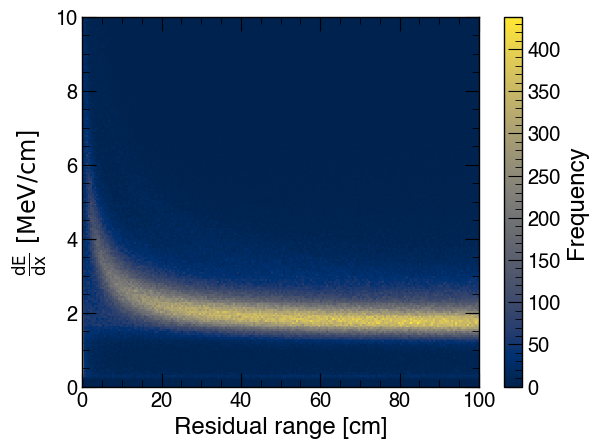

In [6]:
plt.hist2d(hit0_sel_df['rr'], hit0_sel_df['dedx'], bins=200, range = [[0, 100],[0,10]])
plt.colorbar(label='Frequency')
plt.xlabel('Residual range [cm]')
plt.ylabel(r'$\mathrm{\frac{dE}{dx}~[MeV/cm]}$')
plt.savefig('./plots/rr_vs_dedx/2d/rr_vs_dedx_GENIE_CV.pdf')
plt.show()

In [7]:
langau_fit_par_df = rr_vs_dedx_langau(hit0_sel_df, "plane0_", "")

/var/folders/tj/3kjxrxwx2c37zmf4n9j5yh900000gq/T/ipykernel_44191/3660595556.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  out_df = out_df.append(this_row, ignore_index=True)
/var/folders/tj/3kjxrxwx2c37zmf4n9j5yh900000gq/T/ipykernel_44191/3660595556.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  out_df = out_df.append(this_row, ignore_index=True)
/var/folders/tj/3kjxrxwx2c37zmf4n9j5yh900000gq/T/ipykernel_44191/3660595556.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  out_df = out_df.append(this_row, ignore_index=True)
/var/folders/tj/3kjxrxwx2c37zmf4n9j5yh900000gq/T/ipykernel_44191/3660595556.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. U

In [8]:
langau_fit_par_df['sigma_G_err']
negative_sigma_G_rr = langau_fit_par_df[langau_fit_par_df['sigma_G_err'] < 0.]
print(negative_sigma_G_rr)

Empty DataFrame
Columns: [rr, MPV, MPV_err, sigma_L, sigma_L_err, sigma_G, sigma_G_err]
Index: []


In [9]:
def func_dedx_res(x, a0, a1):
    return x * (a0 + a1 * x * x)

def func_deex_res_v1(x, a0, a1, a2):
    return (a0 + a1 * x + a2 * x *x + a3 * x * x * x)


def fit_result_vs_rr(fit_par_df, parname, y_title, prefix, suffix, ymin, ymax, draw_fit_result):
    rr_min = 18.0
    rr_max = 120.0
    cut_rr_min = (fit_par_df.rr > rr_min)
    this_par_df = fit_par_df[cut_rr_min]

    this_par_df['sigma_G_LArSoft'] = this_par_df['MPV'].apply(func_dedx_res, args=(0.04231, 0.0001783))

    fig, ax = plt.subplots()        
    plt.errorbar(
        x = this_par_df['rr'],
        y = this_par_df[parname],
        yerr = this_par_df[parname + '_err'],
        linewidth=2, capsize=1,
        fmt='ok',
        drawstyle = 'default',
        label = 'SBND MC GENIE CV Fit',
        zorder=1
    )
    plt.xlabel('Residual range [cm]')
    plt.ylabel(y_title)
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=ymin, top = ymax)

    # dE/dx res function in LArSoft Chi2PIDAlg
    if parname == 'sigma_G':
        plt.plot(this_par_df['rr'], this_par_df['sigma_G_LArSoft'], 'r-', label='LArSoft Chi2PIDAlg')
        plt.plot([], [], ' ', label=r'$\mathrm{\sigma_{Gauss}}= \frac{dE}{dx} \left( 0.04231 + 0.0001783 \frac{dE}{dx} \times \frac{dE}{dx} \right)$')

        if draw_fit_result:
            this_par_df['sigma_G_fit'] = this_par_df['MPV'].apply(func_dedx_res, args=(0.10419, 0.0118460))
            print(this_par_df['sigma_G_fit'])
            plt.plot(this_par_df['rr'], this_par_df['sigma_G_fit'], 'r-', label='Fit result', color='blue', linestyle='--')
            plt.plot([], [], ' ', label=r'$\mathrm{\sigma_{Gauss}}= \frac{dE}{dx} \left( 0.10419 + 0.0118460 \frac{dE}{dx} \times \frac{dE}{dx} \right)$')


    plt.legend(bbox_to_anchor=(0.15, 0.95), loc='upper left', fontsize=12)
    save_str = './plots/dedx_res/rr_vs_' + parname + '_GENIE_CV.pdf'
    if draw_fit_result:
        save_str = './plots/dedx_res/rr_vs_' + parname + '_GENIE_CV_fit.pdf'
    plt.savefig(save_str)

    del this_par_df

def fit_result_vs_MPV(fit_par_df, parname, y_title, prefix, suffix, do_fit):
    rr_min = 18.0
    rr_max = 120.0
    cut_rr_min = (fit_par_df.rr > rr_min)
    this_par_df = fit_par_df[cut_rr_min]

    this_par_df['sigma_G_LArSoft'] = this_par_df['MPV'].apply(func_dedx_res, args=(0.04231, 0.0001783))
    this_x = this_par_df['MPV']
    this_x_err = this_par_df['MPV_err']
    this_y = this_par_df[parname]
    this_y_err = this_par_df[parname + '_err']

    fig, ax = plt.subplots()        
    plt.errorbar(
        x = this_x,
        xerr = this_x_err,
        y = this_y,
        yerr = this_y_err,
        linewidth=2, capsize=1,
        fmt='ok',
        drawstyle = 'default',
        label = 'SBND MC GENIE CV Fit',
        zorder=1
    )
    plt.xlabel('MPV dE/dx [MeV/cm]')
    plt.ylabel(y_title)
    ax.set_xlim(left=1.6)
    ax.set_ylim(bottom=0., top = 0.7)

    # dE/dx res function in LArSoft Chi2PIDAlg
    if parname == 'sigma_G':
        plt.plot(this_par_df['MPV'], this_par_df['sigma_G_LArSoft'], 'r-', label='LArSoft Chi2PIDAlg')
        plt.plot([], [], ' ', label=r'$\mathrm{\sigma_{G}}= \frac{dE}{dx} \left( 0.04231 + 0.0001783 \frac{dE}{dx} \times \frac{dE}{dx} \right)$')

        if do_fit:
            popt, pcov = curve_fit(
        		func_dedx_res,
		        xdata = this_x,
		        ydata = this_y,
		        sigma = this_y_err,
		        p0 = [0.04231, 0.0001783],
	        )

            fit_a0 = popt[0]
            fit_a0_err = pcov[0][0]
            fit_a1 = popt[1]
            fit_a1_err = pcov[1][1]
            fit_result_x = np.linspace(1.65, 2.45, 500)
            plt.plot(fit_result_x, func_dedx_res(fit_result_x, *popt), 'r-', label='Fit result', color='blue', linestyle='--')
            plt.plot([], [], ' ', label=r'$\mathrm{\sigma_{G}}= \frac{dE}{dx} \left( %5.5f + %5.7f \frac{dE}{dx} \times \frac{dE}{dx} \right)$' % (popt[0], popt[1]))
            #plt.plot([], [], ' ', label=r'$\mathrm{{a}_{0}}$=%5.5f' % popt[0])
            #plt.plot([], [], ' ', label=r'$\mathrm{{a}_{1}}$=%5.7f' % popt[1])

    plt.legend(bbox_to_anchor=(0.10, 0.93), loc='upper left', fontsize=12)
    save_str = './plots/dedx_res/MPV_vs_' + parname + '_GENIE_CV.pdf'
    if do_fit:
        save_str = './plots/dedx_res/MPV_vs_' + parname + '_GENIE_CV_fit.pdf'
    plt.savefig(save_str)

    del this_par_df

/var/folders/tj/3kjxrxwx2c37zmf4n9j5yh900000gq/T/ipykernel_44191/2342806956.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_par_df['sigma_G_LArSoft'] = this_par_df['MPV'].apply(func_dedx_res, args=(0.04231, 0.0001783))
/var/folders/tj/3kjxrxwx2c37zmf4n9j5yh900000gq/T/ipykernel_44191/2342806956.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_par_df['sigma_G_LArSoft'] = this_par_df['MPV'].apply(func_dedx_res, args=(0.04231, 0.0001783))


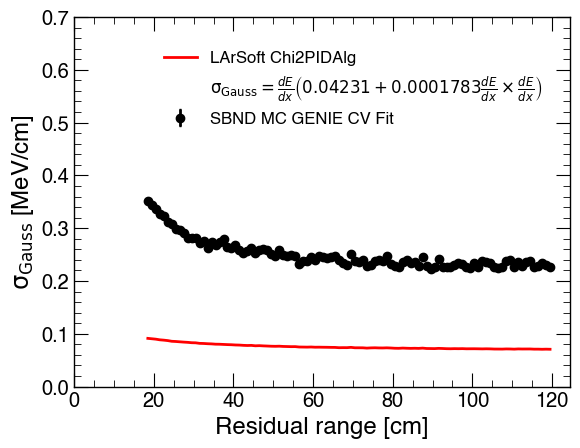

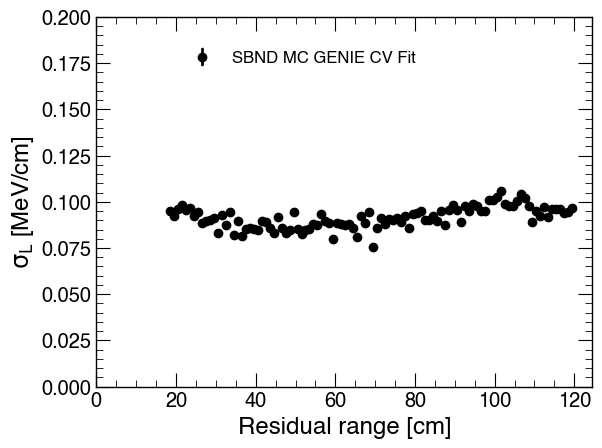

In [10]:
fit_result_vs_rr(langau_fit_par_df, 'sigma_G', r'$\mathrm{\sigma_{Gauss}}$ [MeV/cm]', '','', 0., 0.7, False)
fit_result_vs_rr(langau_fit_par_df, 'sigma_L', r'$\mathrm{\sigma_{L}}$ [MeV/cm]', '','', 0., 0.2, False)


/var/folders/tj/3kjxrxwx2c37zmf4n9j5yh900000gq/T/ipykernel_44191/2342806956.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_par_df['sigma_G_LArSoft'] = this_par_df['MPV'].apply(func_dedx_res, args=(0.04231, 0.0001783))


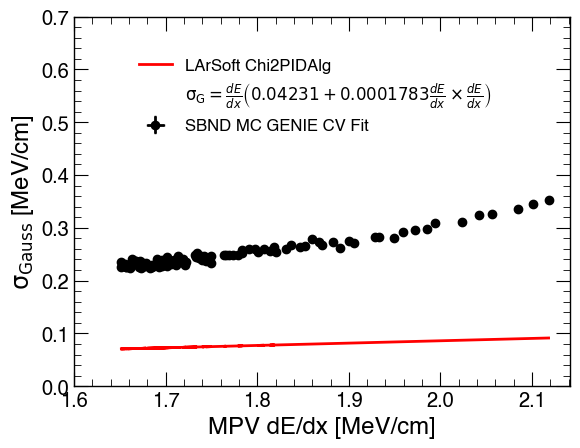

In [11]:
fit_result_vs_MPV(langau_fit_par_df, 'sigma_G', r'$\mathrm{\sigma_{Gauss}}$ [MeV/cm]', '','', False)


/var/folders/tj/3kjxrxwx2c37zmf4n9j5yh900000gq/T/ipykernel_44191/2342806956.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_par_df['sigma_G_LArSoft'] = this_par_df['MPV'].apply(func_dedx_res, args=(0.04231, 0.0001783))
/var/folders/tj/3kjxrxwx2c37zmf4n9j5yh900000gq/T/ipykernel_44191/2342806956.py:100: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(fit_result_x, func_dedx_res(fit_result_x, *popt), 'r-', label='Fit result', color='blue', linestyle='--')
/var/folders/tj/3kjxrxwx2c37zmf4n9j5yh900000gq/T/ipykernel_44191/2342806956.py:100: UserWarning: color is redundantly defined by the 'color' keyword argument

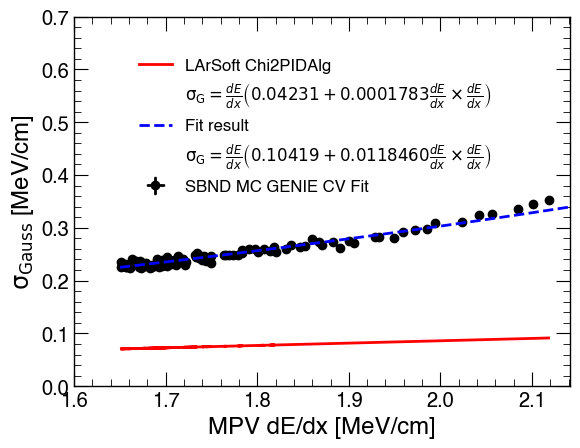

In [12]:
fit_result_vs_MPV(langau_fit_par_df, 'sigma_G', r'$\mathrm{\sigma_{Gauss}}$ [MeV/cm]', '','', True)

/var/folders/tj/3kjxrxwx2c37zmf4n9j5yh900000gq/T/ipykernel_44191/2342806956.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_par_df['sigma_G_LArSoft'] = this_par_df['MPV'].apply(func_dedx_res, args=(0.04231, 0.0001783))
/var/folders/tj/3kjxrxwx2c37zmf4n9j5yh900000gq/T/ipykernel_44191/2342806956.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_par_df['sigma_G_fit'] = this_par_df['MPV'].apply(func_dedx_res, args=(0.10419, 0.0118460))
/var/folders/tj/3kjxrxwx2c37zmf4n9j5yh900000gq/T/ipykernel

15     0.333282
16     0.328877
17     0.324437
18     0.317388
19     0.313745
         ...   
112    0.226360
113    0.226386
114    0.225422
115    0.226276
116    0.225439
Name: sigma_G_fit, Length: 102, dtype: float64


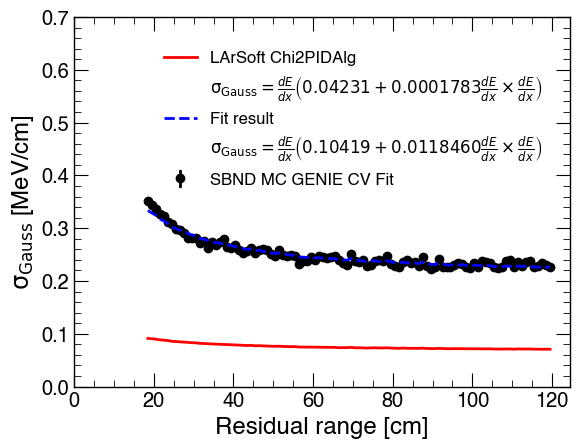

In [13]:
fit_result_vs_rr(langau_fit_par_df, 'sigma_G', r'$\mathrm{\sigma_{Gauss}}$ [MeV/cm]', '','', 0., 0.7, True)

In [14]:
# chi2 distributions

## Load pickle file with 10 cm trk len cut
out_path = "/Users/sungbino/Study/FNAL/SBND/calib/chi2_pid/pickle/"
with open(os.path.join(out_path, "hit0_sel_df_trk_len_10.pkl"), 'rb') as f:
    hit0_sel_df = pickle.load(f)

LArSoft_template_file = uproot.open("./inputs/dEdxrestemplates.root")
chi2_profile_map = {
    "kaon": "dedx_range_ka",
    "proton": "dedx_range_pro",
    "muon": "dedx_range_mu",
    "pion": "dedx_range_pi"
}
chi2_profiles = {key: LArSoft_template_file[value] for key, value in chi2_profile_map.items()}
chi2_dEdx_arrs = {key: chi2_profiles[key].values() for key in chi2_profile_map}
chi2_rr_arrs = {key: chi2_profiles[key].axis().edges() for key in chi2_profile_map}
chi2_yerr_arrs = {key: chi2_profiles[key].errors(error_mode="s") for key in chi2_profile_map}

for key, dEdx_arrs in chi2_dEdx_arrs.items():
    for i in range(len(dEdx_arrs)):
        if dEdx_arrs[i] < 1e-6:
            print("dEdx " + key + " " + str(dEdx_arrs[i]) + " in " + str(i) + "/" + str(len(dEdx_arrs)-1))
            dEdx_arrs[i] = (dEdx_arrs[i-1] + dEdx_arrs[i+1]) / 2
            print("to " + str(dEdx_arrs[i]))

for key, yerr_arr in chi2_yerr_arrs.items():
    for i in range(len(yerr_arr)):
        if yerr_arr[i] < 1e-6:
            print("yerr " + key + " " + str(yerr_arr[i]) + " in " + str(i) + "/" + str(len(yerr_arr)-1))
            yerr_arr[i] = (yerr_arr[i-1] + yerr_arr[i+1]) / 2
            if i == 302:
                yerr_arr[i] = (yerr_arr[i+1]) / 2
            print("to " + str(yerr_arr[i]))

dEdx proton 0.0 in 297/324
to 4.554094398021698
dEdx proton 0.0 in 299/324
to 4.644259949525198
yerr proton 0.0 in 297/324
to 0.17390959207421958
yerr proton 0.0 in 299/324
to 0.1427214451446406
yerr proton 0.0 in 301/324
to 0.06971746306982854
yerr proton 0.0 in 302/324
to 0.09049999713897705


In [15]:
def particle_chi2(dEdx, ResRange, particle, dedx_a0, dedx_a1):
    if particle != "kaon" and particle != "proton" and particle != "muon" and particle != "pion" :
        print("Not a valid particle input")
        return 99999.
    if len(dEdx) < 1 or len(ResRange) < 1:
        return 88888.0
    
    N_max_hits = 1000
    this_N_calo = len(dEdx)
    this_N_hits = min(N_max_hits, this_N_calo)
    N_skip = 0
    dEdx_truncate_upper = 1000.0
    dEdx_truncate_bellow = 0.0
    this_chi2 = 0.0
    npt = 0

    dedx_exp = pd.cut(ResRange, chi2_rr_arrs[particle], labels=chi2_dEdx_arrs[particle]).astype(float)
    dedx_err = pd.cut(ResRange, chi2_rr_arrs[particle], labels=chi2_yerr_arrs[particle]).astype(float)
    dedx_res = (dedx_a0 + dedx_a1*dEdx**2)*dEdx

    v_chi2 = (dEdx - dedx_exp)**2 / (dedx_err**2 + dedx_res**2)

    when_chi2 = (ResRange < np.max(chi2_rr_arrs[particle])) & (ResRange > 0.) & (dEdx < dEdx_truncate_upper)  & (dEdx > dEdx_truncate_bellow)
    
    chi2_series = v_chi2[when_chi2]
    #print(ResRange[when_chi2])
    len_all = len(chi2_series)
    len_skipped = len(chi2_series.iloc[N_skip:len_all - 1 - N_skip])

    if(len_skipped) < 1:
        return 77777.0

    return chi2_series.iloc[N_skip:len_all - 1 - N_skip].sum() / len_skipped

def calculate_chi2_for_entry(group, particle, dedx_a0 = 0.04231, dedx_a1 = 0.0001783):
    return particle_chi2(group['dedx'], group['rr'], particle, dedx_a0, dedx_a1)

In [16]:
chi2_proton_repro = hit0_sel_df.groupby('entry').apply(lambda group: calculate_chi2_for_entry(group, "proton"))
chi2_muon_repro = hit0_sel_df.groupby('entry').apply(lambda group: calculate_chi2_for_entry(group, "muon"))


In [17]:
chi2_df = hit0_sel_df.groupby('entry')[[('chi2pid', 'I0', 'chi2_proton')]].apply(get_last)
chi2_df['chi2_I0_proton_repro'] = chi2_proton_repro
chi2_df[('chi2pid', 'I0', 'chi2_muon')] = hit0_sel_df.groupby('entry')[[('chi2pid', 'I0', 'chi2_muon')]].apply(get_last)
chi2_df['chi2_I0_muon_repro'] = chi2_muon_repro

In [18]:
chi2_df

,"(chi2pid, I0, chi2_proton)",chi2_I0_proton_repro,"(chi2pid, I0, chi2_muon)",chi2_I0_muon_repro
entry,,,,
2,55.321217,55.026878,41.458080,41.006753
11,109.812737,109.812739,1.656730,1.656730
13,139.658264,139.658267,1.223389,1.223389
14,230.669724,235.069481,11.778390,11.760100
16,37.815174,37.654200,42.585106,42.709765
...,...,...,...,...
102165,110.217194,110.217196,2.472215,2.472215
102166,116.091537,116.091536,32.754814,32.754815
102168,194.033295,194.033290,7.825248,7.825248


In [19]:
chi2_repro_df = chi2_proton_repro.reset_index(name='chi2_proton_rep')
chi2_repro_df['chi2_muon_rep'] = chi2_muon_repro.reset_index(name='chi2_muon_rep')['chi2_muon_rep']
hit0_sel_df = pd.merge(hit0_sel_df, chi2_repro_df, on='entry', how='left')

In [20]:
#chi2_proton_new_fit = hit0_sel_df.groupby('entry').apply(lambda group: calculate_chi2_for_entry(group, "proton", 0.10419, 0.0118460))
#chi2_muon_new_fit = hit0_sel_df.groupby('entry').apply(lambda group: calculate_chi2_for_entry(group, "muon", 0.10419, 0.0118460))
chi2_proton_new_fit = hit0_sel_df.groupby('entry').apply(lambda group: calculate_chi2_for_entry(group, "proton", 0., 0.))
chi2_muon_new_fit = hit0_sel_df.groupby('entry').apply(lambda group: calculate_chi2_for_entry(group, "muon", 0., 0.))

In [21]:
chi2_new_fit_dr = chi2_proton_new_fit.reset_index(name='chi2_proton_new_fit')
chi2_new_fit_dr['chi2_muon_new_fit'] = chi2_muon_new_fit.reset_index(name='chi2_muon_new_fit')['chi2_muon_new_fit']
hit0_sel_df = pd.merge(hit0_sel_df, chi2_new_fit_dr, on='entry', how='left')

In [22]:
hit0_sel_df

,entry,rec.slc..index,rec.slc.reco.pfp..index,rec.slc.reco.pfp.trk.calo.points..index,dqdx,dedx,rr,pitch,"(slc, self, )","(slc, charge, )",...,"(p, genp, y)","(p, genp, z)","(p, genE, )","(p, length, )","(p, cont_tpc, )","(reco, pfp, trackScore)",chi2_proton_rep,chi2_muon_rep,chi2_proton_new_fit,chi2_muon_new_fit
0,2,1,0,0,1587.487061,3.068288,24.813457,0.304049,67,3.402823e+38,...,0.429893,0.552847,1.170890,27.062431,1,0.637455,55.026878,41.006753,104.961065,92.551195
1,2,1,0,1,2820.927979,6.889038,24.487707,0.303926,67,3.402823e+38,...,0.429893,0.552847,1.170890,27.062431,1,0.637455,55.026878,41.006753,104.961065,92.551195
2,2,1,0,2,2968.895508,7.484742,24.144789,0.303722,67,3.402823e+38,...,0.429893,0.552847,1.170890,27.062431,1,0.637455,55.026878,41.006753,104.961065,92.551195
3,2,1,0,3,2807.429199,6.835895,23.806946,0.303599,67,3.402823e+38,...,0.429893,0.552847,1.170890,27.062431,1,0.637455,55.026878,41.006753,104.961065,92.551195
4,2,1,0,4,2833.939209,6.939282,23.474327,0.303412,67,3.402823e+38,...,0.429893,0.552847,1.170890,27.062431,1,0.637455,55.026878,41.006753,104.961065,92.551195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3351664,102175,0,0,253,3460.203369,9.463831,2.063481,0.537013,20,3.402823e+38,...,0.317906,0.017321,0.442584,136.856735,0,0.654182,110.855829,4.212066,134.077972,7.047992
3351665,102175,0,0,254,3879.729248,11.669556,1.526540,0.532508,20,3.402823e+38,...,0.317906,0.017321,0.442584,136.856735,0,0.654182,110.855829,4.212066,134.077972,7.047992
3351666,102175,0,0,255,4823.628906,18.166372,0.923580,0.530284,20,3.402823e+38,...,0.317906,0.017321,0.442584,136.856735,0,0.654182,110.855829,4.212066,134.077972,7.047992
3351667,102175,0,0,256,4347.085938,14.580816,0.387817,0.528003,20,3.402823e+38,...,0.317906,0.017321,0.442584,136.856735,0,0.654182,110.855829,4.212066,134.077972,7.047992


In [23]:
def draw_chi2_plots(column1, column2, label1, label2, title_x, title_y, N_bins, x_min, x_max, y_min = 0, y_max = 0.5, save_str="noname"):
    fig, ax = plt.subplots()
    ax.set_xlim(left=x_min, right = x_max)
    #ax.set_ylim(bottom=y_min, top = y_max)
    plt.xlabel(title_x)
    plt.ylabel(title_y)
    plt.subplots_adjust(top = 0.95, bottom=0.15) 
    plt.hist(column1, bins=np.linspace(x_min, x_max, N_bins), histtype="step", color = 'red', label = label1, density=True)
    plt.hist(column2, bins=np.linspace(x_min, x_max, N_bins), histtype="step", color = 'blue', label = label2, density=True)
    plt.legend(bbox_to_anchor=(0.50, 0.93), loc='upper left', fontsize=15)

    save_str = './plots/chi2PID/' + save_str
    plt.savefig(save_str)


In [24]:
bool_true_muon = ((hit0_sel_df[('p', 'pdg', '')] == 13) | (hit0_sel_df[('p', 'pdg', '')] == -13))
bool_true_proton = (hit0_sel_df[('p', 'pdg', '')] == 2212)

true_proton_orig_chi2_proton = hit0_sel_df[bool_true_proton].groupby('entry')[[('chi2pid', 'I0', 'chi2_proton')]].apply(get_last)
true_proton_orig_chi2_muon = hit0_sel_df[bool_true_proton].groupby('entry')[[('chi2pid', 'I0', 'chi2_muon')]].apply(get_last)
true_proton_new_fit_chi2_proton = hit0_sel_df[bool_true_proton].groupby('entry')[['chi2_proton_new_fit']].apply(get_last)
true_proton_new_fit_chi2_muon = hit0_sel_df[bool_true_proton].groupby('entry')[['chi2_muon_new_fit']].apply(get_last)

true_muon_orig_chi2_proton = hit0_sel_df[bool_true_muon].groupby('entry')[[('chi2pid', 'I0', 'chi2_proton')]].apply(get_last)
true_muon_orig_chi2_muon = hit0_sel_df[bool_true_muon].groupby('entry')[[('chi2pid', 'I0', 'chi2_muon')]].apply(get_last)
true_muon_new_fit_chi2_proton = hit0_sel_df[bool_true_muon].groupby('entry')[['chi2_proton_new_fit']].apply(get_last)
true_muon_new_fit_chi2_muon = hit0_sel_df[bool_true_muon].groupby('entry')[['chi2_muon_new_fit']].apply(get_last)

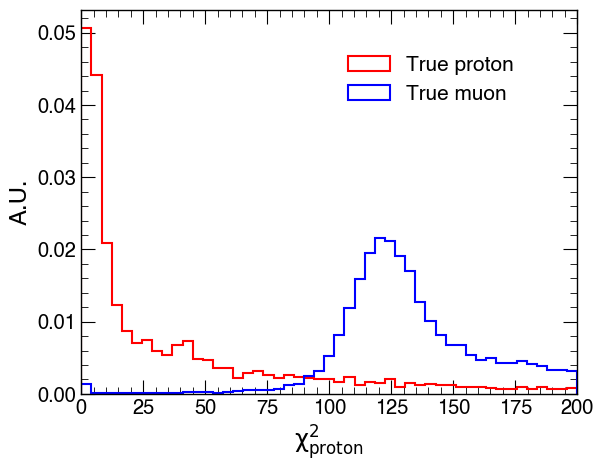

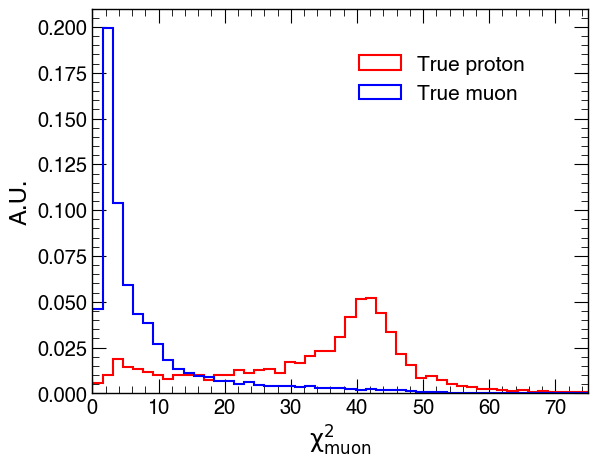

In [25]:
draw_chi2_plots(true_proton_orig_chi2_proton, true_muon_orig_chi2_proton, "True proton", "True muon", r'$\mathrm{{\chi}^{2}_{proton}}$', 'A.U.', 50, 0., 200., save_str='orig_chi2_proton_comp.pdf')
draw_chi2_plots(true_proton_orig_chi2_muon, true_muon_orig_chi2_muon, "True proton", "True muon", r'$\mathrm{{\chi}^{2}_{muon}}$', 'A.U.', 50, 0., 75., save_str='orig_chi2_muon_comp.pdf')

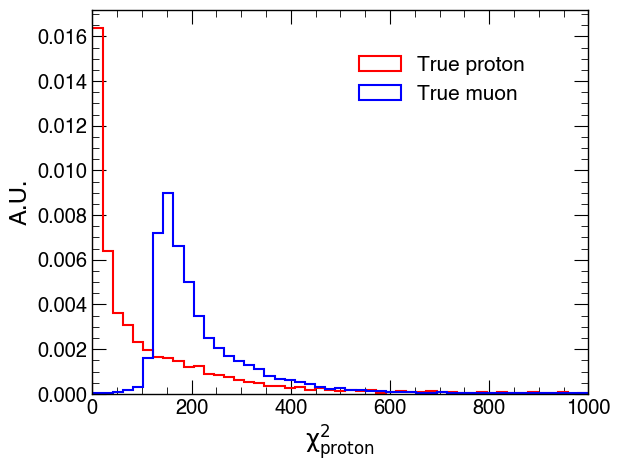

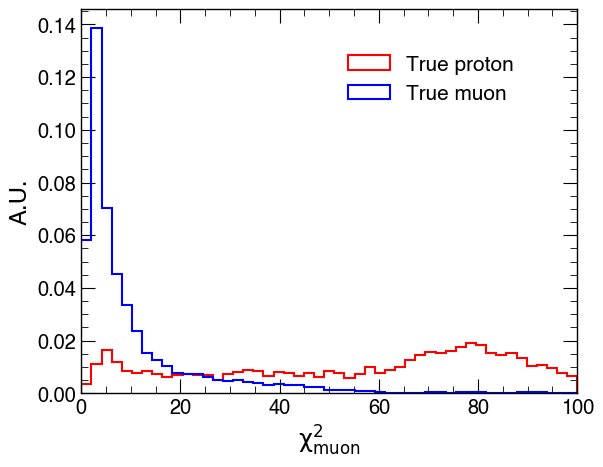

In [34]:
draw_chi2_plots(true_proton_new_fit_chi2_proton, true_muon_new_fit_chi2_proton, "True proton", "True muon", r'$\mathrm{{\chi}^{2}_{proton}}$', 'A.U.', 50, 0., 1000., save_str='new_fit_chi2_proton_comp.pdf')
draw_chi2_plots(true_proton_new_fit_chi2_muon, true_muon_new_fit_chi2_muon, "True proton", "True muon", r'$\mathrm{{\chi}^{2}_{muon}}$', 'A.U.', 50, 0., 100., save_str='new_fit_chi2_muon_comp.pdf')

In [35]:
# Test mu proton seperation performance
orig_chi2_proton_wps = np.linspace(1, 300, 300)
orig_chi2_muon_wps = np.linspace(1, 70, 70)
new_fit_chi2_proton_wps = np.linspace(0, 500, 1000)
new_fit_chi2_muon_wps = np.linspace(0, 500, 1000)

orig_chi2_proton_perf_df = pd.DataFrame(orig_chi2_proton_wps, columns=['wp'])
orig_chi2_muon_perf_df = pd.DataFrame(orig_chi2_muon_wps, columns=['wp'])
new_fit_chi2_proton_perf_df = pd.DataFrame(new_fit_chi2_proton_wps, columns=['wp'])
new_fit_chi2_muon_perf_df = pd.DataFrame(new_fit_chi2_muon_wps, columns=['wp'])

In [36]:
def meas_eff(threshold, df, column):
    total_len = len(df)
    count = (df[column] < threshold).sum()
    return (count/total_len).astype(float)

In [37]:
orig_chi2_proton_perf_df['proton_eff'] = orig_chi2_proton_perf_df['wp'].apply(
    lambda x: meas_eff(x, true_proton_orig_chi2_proton, [('chi2pid', 'I0', 'chi2_proton')])
)
orig_chi2_proton_perf_df['muon_eff'] = orig_chi2_proton_perf_df['wp'].apply(
    lambda x: meas_eff(x, true_muon_orig_chi2_proton, [('chi2pid', 'I0', 'chi2_proton')])
)
orig_chi2_muon_perf_df['proton_eff'] = orig_chi2_proton_perf_df['wp'].apply(
    lambda x: meas_eff(x, true_proton_orig_chi2_muon, [('chi2pid', 'I0', 'chi2_muon')])
)
orig_chi2_muon_perf_df['muon_eff'] = orig_chi2_proton_perf_df['wp'].apply(
    lambda x: meas_eff(x, true_muon_orig_chi2_muon, [('chi2pid', 'I0', 'chi2_muon')])
)

new_fit_chi2_proton_perf_df['proton_eff'] = new_fit_chi2_proton_perf_df['wp'].apply(
    lambda x: meas_eff(x, true_proton_new_fit_chi2_proton, ['chi2_proton_new_fit'])
)
new_fit_chi2_proton_perf_df['muon_eff'] = new_fit_chi2_proton_perf_df['wp'].apply(
    lambda x: meas_eff(x, true_muon_new_fit_chi2_proton, ['chi2_proton_new_fit'])
)
new_fit_chi2_muon_perf_df['proton_eff'] = new_fit_chi2_muon_perf_df['wp'].apply(
    lambda x: meas_eff(x, true_proton_new_fit_chi2_muon, ['chi2_muon_new_fit'])
)
new_fit_chi2_muon_perf_df['muon_eff'] = new_fit_chi2_muon_perf_df['wp'].apply(
    lambda x: meas_eff(x, true_muon_new_fit_chi2_muon, ['chi2_muon_new_fit'])
)

In [38]:
new_fit_chi2_muon_perf_df

,wp,proton_eff,muon_eff
0,0.000000,0.000000,0.000000
1,0.500501,0.000185,0.000352
2,1.001001,0.000739,0.004293
3,1.501502,0.001479,0.034488
4,2.002002,0.005176,0.107264
...,...,...,...
995,497.997998,0.918854,0.979378
996,498.498498,0.919039,0.979378
997,498.998999,0.919224,0.979378
998,499.499499,0.919224,0.979378


In [39]:
def draw_eff_vs_fake_plot(df1, df2, label1, label2, x_column, y_column, title_x, title_y, save_str):
    fig, ax = plt.subplots()
    ax.set_xlim(left=0., right = 1.)
    ax.set_ylim(bottom=0., top = 1.)
    plt.xlabel(title_x)
    plt.ylabel(title_y)
    plt.subplots_adjust(top = 0.95, bottom=0.15)
    plt.plot(df1[x_column], df1[y_column], 'r-', label=label1, color='blue')
    plt.plot(df2[x_column], df2[y_column], 'r-', label=label2, color='red', linestyle='--')
    plt.legend(bbox_to_anchor=(0.50, 0.4), loc='upper left', fontsize=15)

    save_str = './plots/chi2PID/' + save_str
    plt.savefig(save_str)

/var/folders/tj/3kjxrxwx2c37zmf4n9j5yh900000gq/T/ipykernel_44191/2553436614.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(df1[x_column], df1[y_column], 'r-', label=label1, color='blue')
/var/folders/tj/3kjxrxwx2c37zmf4n9j5yh900000gq/T/ipykernel_44191/2553436614.py:9: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(df2[x_column], df2[y_column], 'r-', label=label2, color='red', linestyle='--')
/var/folders/tj/3kjxrxwx2c37zmf4n9j5yh900000gq/T/ipykernel_44191/2553436614.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(df2[x_column], df2[y_column], 'r-', label=label2, color='red', linestyle='--')
/var/folders/tj/

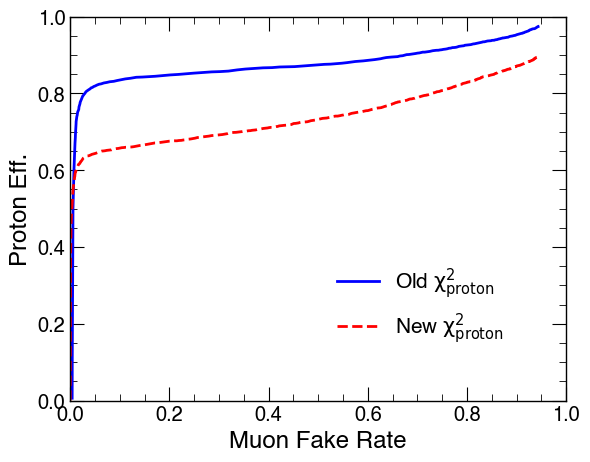

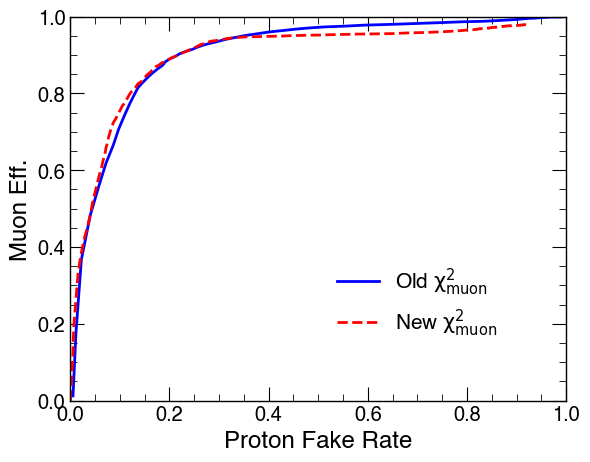

In [40]:
draw_eff_vs_fake_plot(orig_chi2_proton_perf_df, new_fit_chi2_proton_perf_df, r'Old $\mathrm{{\chi}^{2}_{proton}}$', r'New $\mathrm{{\chi}^{2}_{proton}}$', 'muon_eff', 'proton_eff', 'Muon Fake Rate', 'Proton Eff.', 'perf_comp_proton_chi2.pdf')
draw_eff_vs_fake_plot(orig_chi2_muon_perf_df, new_fit_chi2_muon_perf_df, r'Old $\mathrm{{\chi}^{2}_{muon}}$', r'New $\mathrm{{\chi}^{2}_{muon}}$', 'proton_eff', 'muon_eff', 'Proton Fake Rate', 'Muon Eff.', 'perf_comp_muon_chi2.pdf')
